In [1]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm
import shap

os.chdir("..")
from utils.utils import *
from shap_analysis.supporting_functions import *
from shap_analysis.plotting import *

os.chdir("..")

In [ ]:
# load data for maps

# shape file with data on the municipal level
m_shape_df = gpd.read_file("data/maps/VG250_GEM.shp", decimal=",", encoding="UTF-8")
m_shape_df["AGS"] = m_shape_df["AGS"].astype(int)

# mapping from municipalities to municipality associations
df_mapping = pd.read_csv(
    "data/intermediate_data/mapping_municipalities_2000_2019.csv",
    sep=";",
    dtype={"Official municipality code (AGS)": "int"},
)

m_shape_incl_mapping = pd.merge(
    left=m_shape_df,
    right=df_mapping[
        ["AGS", "Name of municipality ass.", "Code of municipality associations (RS)"]
    ],
    on="AGS",
    how="left",
)

# explanantory variables and target feature
df_data = pd.read_csv("data/input/input.csv", sep=";")
df_predictions = pd.read_csv("data/output/predictions_rfe.csv", sep=";")


m_shape_incl_values = pd.merge(
    left=m_shape_incl_mapping, right=df_data, on=col_id_ma, how="left"
)
m_shape_incl_values = pd.merge(
    left=m_shape_incl_values, right=df_predictions, on=col_id_ma, how="left"
)

### Map of target feature (displayed in figure 1)

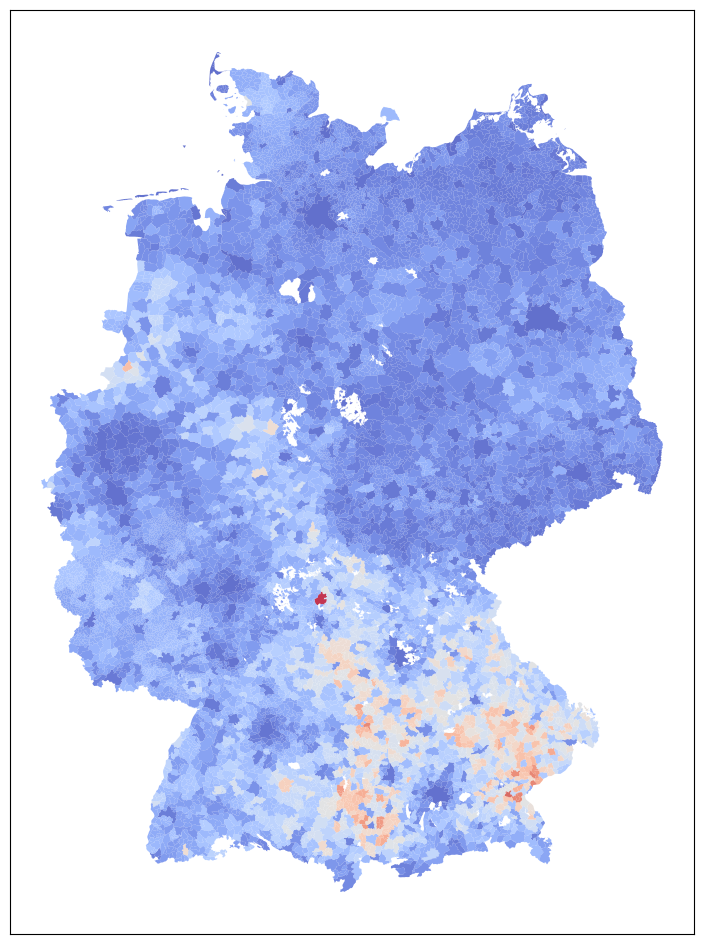

In [10]:
fig, ax = plt.subplots(figsize=(12, 12))
cbar = m_shape_incl_values.plot(
    ax=ax,
    column=col_power_accum_pv,
    categorical=False,
    legend=False,
    cmap="coolwarm",
    alpha=0.8,
)
plt.tick_params(
    axis="both",
    which="both",
    bottom=False,
    labelbottom=False,
    top=False,
    left=False,
    labelleft=False,
)
ax.set_facecolor("white")
plt.show()

### Map of predictions (displayed in figure 1)

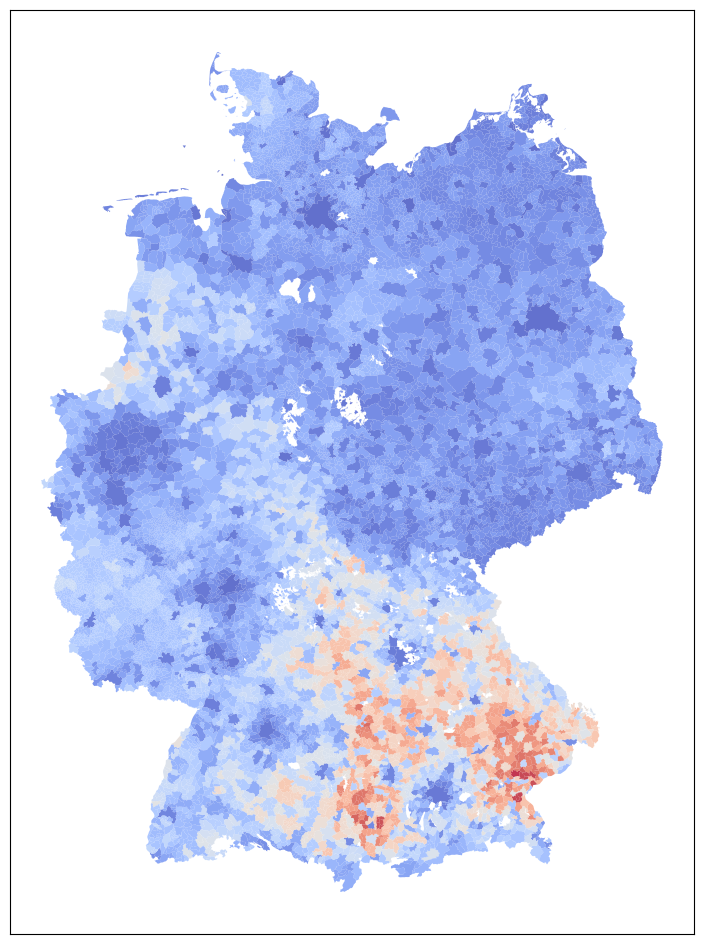

In [11]:
# map predictions
fig, ax = plt.subplots(figsize=(12, 12))
cbar = m_shape_incl_values.plot(
    ax=ax,
    column=col_predictions,
    categorical=False,
    legend=False,
    cmap="coolwarm",
    alpha=0.8,
)
plt.tick_params(
    axis="both",
    which="both",
    bottom=False,
    labelbottom=False,
    top=False,
    left=False,
    labelleft=False,
)
ax.set_facecolor("white")
plt.show()

### Map of ownership ratio (displayed in figure 1)

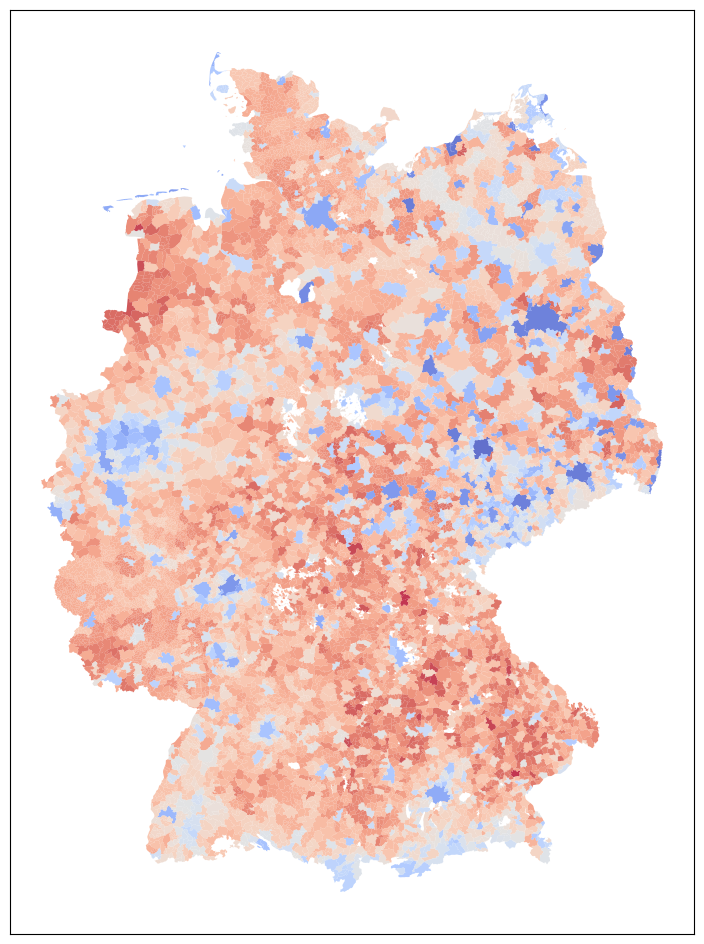

In [12]:
# map ownership occupation ratio
fig, ax = plt.subplots(figsize=(12, 12))
cbar = m_shape_incl_values.plot(
    ax=ax,
    column="ownership occupation ratio",
    categorical=False,
    legend=False,
    cmap="coolwarm",
    alpha=0.8,
)
plt.tick_params(
    axis="both",
    which="both",
    bottom=False,
    labelbottom=False,
    top=False,
    left=False,
    labelleft=False,
)
ax.set_facecolor("white")
plt.show()

### SHAP analysis (displayed in figure 1)

In [2]:
# get data for SHAP analysis
df_performances = pd.read_csv(f"data/output/results_rfe.csv", sep=";")
df_performances = prepare_performance_dataframe(df_performances, "features")

df_metadata = pd.read_csv(f"data/output/metadata_rfe.csv", sep=";")
df_metadata = prepare_metadata_dataframe(
    df_metadata, ["indices_training_set", "indices_val_set", "indices_test_set"]
)

df_data = pd.read_csv(df_metadata[col_file_path].unique()[0], sep=";")
df_predictions = pd.read_csv("data/output/predictions_rfe.csv", sep=";")

In [3]:
split_id_best_model = 4
feature_count_threshold = 15

In [4]:
df_performance_red_model = df_performances.loc[
    (df_performances[col_run_id] == split_id_best_model)
    & (df_performances[col_feature_count] == feature_count_threshold)
    & (df_performances[ranking_mean_r2_desc] == 1),
    :,
]
X_red_model = df_data[df_performance_red_model[col_features].values[0]]
model_dict = get_fitted_models(
    df_perf=df_performances,
    df_metadata=df_metadata,
    feat_count_red_model=feature_count_threshold,
    target_feat=col_power_accum_pv,
    train_on_train_val=True,
)
red_model = model_dict[split_id_best_model]
y_pred = red_model.predict(X_red_model)
tree_explainer = shap.explainers.Tree(red_model)
shap_values = tree_explainer.shap_values(X_red_model)

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightG

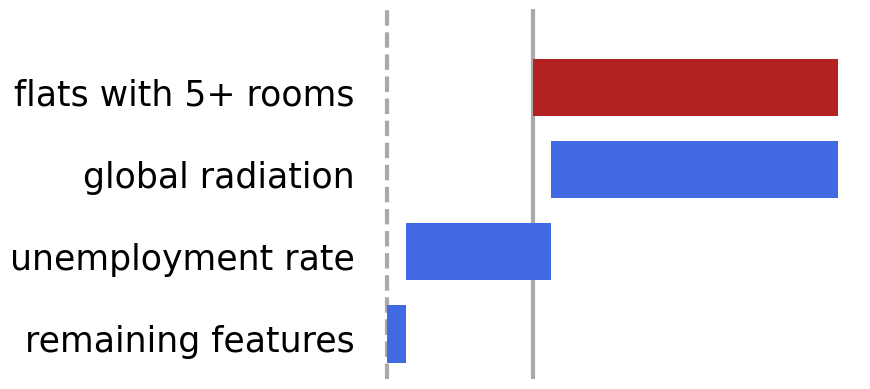

In [5]:
# waterfall plot for exemplary city (Monschau, RS: 53340020)
plt.style.use("default")

idx_city = df_data.loc[df_data[col_id_ma] == 53340020].index
shap_city = shap_values[idx_city, :]
shap_city = shap_city[0]
idx_sorted = np.argsort(np.abs(shap_city))[::-1]

mean_plus_shap = df_predictions[col_predictions].mean()

fig, ax = plt.subplots()
# total number of input features: count_features
count_features = 15
# plot k features with shap values of largest magnitude
k = 3
for idx, ranking_feature in enumerate(range(k)):
    if shap_city[idx_sorted[ranking_feature]] >= 0:
        ax.broken_barh(
            [(mean_plus_shap, shap_city[idx_sorted[ranking_feature]])],
            (11 + idx * 10, 7),
            facecolors=("firebrick"),
            zorder=2,
        )
        mean_plus_shap += shap_city[idx_sorted[ranking_feature]]
    else:
        ax.broken_barh(
            [
                (
                    (mean_plus_shap + shap_city[idx_sorted[ranking_feature]]),
                    np.abs(shap_city[idx_sorted[ranking_feature]]),
                )
            ],
            (11 + idx * 10, 7),
            facecolors=("royalblue"),
            zorder=2,
        )
        mean_plus_shap += shap_city[idx_sorted[ranking_feature]]
if k < count_features:
    shap_remaining = sum(shap_city[idx_sorted[k:]])
    if shap_remaining >= 0:
        ax.broken_barh(
            [(mean_plus_shap, shap_remaining)],
            (11 + k * 10, 7),
            facecolors=("firebrick"),
            zorder=2,
        )
    else:
        ax.broken_barh(
            [(mean_plus_shap + shap_remaining, np.abs(shap_remaining))],
            (11 + k * 10, 7),
            facecolors=("royalblue"),
            zorder=2,
        )
    ax.set_ylim(5, (k + 2) * 10)
    ax.set_yticks(
        range(15, 15 + (k + 1) * 10, 10),
        # labels=[
        #     "global radiation"
        #     if X_red_model.columns[ranking_feature] == "Global irradiation"
        #     else X_red_model.columns[ranking_feature]
        #     for ranking_feature in idx_sorted[:k]
        # ]
        labels=X_red_model.columns[idx_sorted[:k]].to_list() + ["remaining features"],
    )

    mean_plus_shap += shap_remaining
else:
    ax.set_ylim(5, (k + 1) * 10)
    ax.set_yticks(
        range(15, 15 + k * 10, 10),
        labels=[
            X_red_model.columns[ranking_feature] for ranking_feature in idx_sorted[:k]
        ],
    )
ax.invert_yaxis()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.axvline(x=np.mean(y_pred), color="darkgray", zorder=1, linewidth=3)
plt.axvline(x=mean_plus_shap, color="darkgray", ls="--", zorder=1, linewidth=3)
ax.spines[["right", "bottom", "top", "left"]].set_visible(False)

plt.tick_params(left=False)
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.show()

['global radiation' 'flats with 5+ rooms' 'share 4-person households']
[0.01236051 0.01541033 0.01575874]


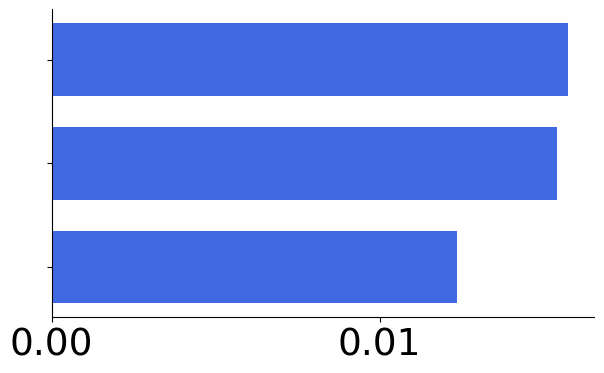

In [6]:
# plot feature importances 3 features

fig, ax = bar_shap_reduced(
    X_red_model,
    shap_values,
    bar_color="royalblue",
    show_std=False,
    title="SHAP feature importances",
    n_print=3,
)

#### Dependence plot (Displayed in figure 1)
See notebook analysis_gbt.ipynb.